In [1]:
#import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannot import add_stat_annotation
from matplotlib.lines import Line2D
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, kruskal
import pingouin as pg

# set rcParams to be able to easily edit text in illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'  
plt.rcParams['font.sans-serif'] = ['Arial']  

# Get data

In [19]:

cohort2 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/totalvol_Cohort2.xlsx')
cohort1_30 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/totalvol_Cohort1_PND30.xlsx')
cohort1_90 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/totalvol_Cohort1_PND90.xlsx')
cohort1_exvivo = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/totalvol_Cohort1_exvivo.xlsx')


In [20]:

cohort2.head(1)

,subject,vol,Sex,Genotype
0,COMR141a,433.692,M,KO


## Calculate change between over time (∆adulthood–adolescence) and between in vivo and ex vivo scans

In [21]:
# map all on subject to ensure alignment
cohort1_30['exvivo'] = cohort1_30['subject'].map(cohort1_exvivo.set_index('subject')['vol'])
cohort1_30['90'] = cohort1_30['subject'].map(cohort1_90.set_index('subject')['vol'])

# calculate change from day 30 to day 90 and change between in vivo and ex vivo
cohort1_30['maturation_change']= cohort1_30['90']-cohort1_30['vol']
cohort1_30['exvivo_change']= cohort1_30['exvivo']-cohort1_30['90']

## Plotting and preliminary stats

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.286e-02 stat=5.835e+00
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.463e-02
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=3.868e-01
M_WT v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.294e-02 stat=6.982e+00


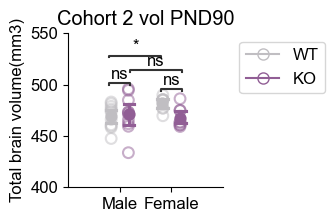

In [22]:

# function for plotting and stats
def plot_events(dataframe, y_column, file_path, ylim=None, title=None, ylabel=None):
    # create figure and axis
    f, ax = plt.subplots(figsize=(2, 2))
    # define the desired order for 'Sex'
    desired_order = ['M', 'F']
    # define the color palette for Group_ID and Sex
    palette = {
        ('WT', 'M'): '#c0bec2',  
        ('WT', 'F'): '#c0bec2', 
        ('KO', 'M'): '#915e95',  
        ('KO', 'F'): '#915e95'  
    }
    # manually plot data points with custom markers for Group_ID (WT and KO)
    marker_size = 60  # size of markers
    x_spacing = 0.1  # spacing between 'WT' and 'KO' markers within each sex

    # iterate over each sex in the desired order
    for i, sex in enumerate(desired_order):
        # filter data for the current sex
        sex_data = dataframe[dataframe['Sex'] == sex]

        # calculate x-coordinate for scatter plot based on the desired order
        x_position = i

        # iterate over each row in the filtered data
        for j, row in sex_data.iterrows():
            # determine x-coordinate based on group
            x_offset = -x_spacing / 0.6 if row['Genotype'] == 'WT' else x_spacing / 0.6

            # calculate final x-coordinate with offset
            x_coordinate = x_position + x_offset

            # determine marker and color based on 'Group_ID'
            marker = 'o' if sex == 'M' else 'o'
            color = palette[(row['Genotype'], sex)]

            # plot scatter point
            ax.scatter(x_coordinate, row[y_column], linewidth=1.5,color=color,facecolor='none', marker=marker, s=marker_size, alpha=0.5)


    # plot the pointplot with custom markers
    sns.pointplot(x='Sex', y=y_column, markers=['o', 'o'], hue='Genotype', palette={'WT': '#c0bec2', 'KO': '#915e95'}, hue_order=['WT', 'KO'],order=desired_order, dodge=0.35,
                  data=dataframe, ax=ax, errorbar=('ci', 95), capsize=0.2, scale=1, join=False, errwidth=2.25)


 # add statistical annotations for all four comparisons
    box_pairs = [
        (('M', 'WT'), ('M', 'KO')),
        (('F', 'WT'), ('F', 'KO')),
        (('M', 'KO'), ('F', 'KO')),
        (('F', 'WT'), ('M', 'WT'))
    ]
    test_order=['WT', 'KO']
    add_stat_annotation(ax, perform_stat_test=True, order=desired_order, hue_order=test_order,data=dataframe, x='Sex', y=y_column, hue='Genotype', box_pairs=box_pairs,
                        test='Kruskal', pvalues=None, text_format='star', loc='inside', verbose=2, comparisons_correction='bonferroni')

    # despine the plot
    sns.despine()

    # set plot limits and labels
    ax.set_xlim(-1, 2)
    if ylim:
        ax.set_ylim(*ylim)
        ax.yaxis.set_ticks(np.arange(ylim[0], ylim[1] + 1, 50))
    if title:
        ax.set_title(title)
    if ylabel:
        ax.set_ylabel(ylabel)

    # customise x-axis tick labels
    tick_positions = range(len(desired_order))
    ax.set_xticks(tick_positions)
    tick_labels = ['Male', 'Female']  

    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('')

    # create custom legend handles for Group_ID (WT and KO)
    legend_handles = [
        Line2D([0], [0], marker='o', color='#c0bec2', markerfacecolor='none', markersize=8, markeredgewidth=1, label='WT'),
        Line2D([0], [0], marker='o', color='#915e95', markerfacecolor='none', markersize=8, markeredgewidth=1, label='KO')
    ]

    # legend outside the plot area
    ax.legend(handles=legend_handles, loc='upper left', title='', bbox_to_anchor=(1.05, 1))

    # save
    plt.savefig(file_path, bbox_inches='tight')

# Cohort 2
plot_events(cohort2, 'vol', '/Users/hannalemmik/Dropbox/KO_paper/volume/Cohort2_total_vol.pdf', ylim=(400, 550), title='Cohort 2 vol PND90', ylabel='Total brain volume(mm3)')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.102e-01 stat=3.115e+00
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.121e-01
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.985e-01 stat=2.076e+00
M_WT v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.714e-01


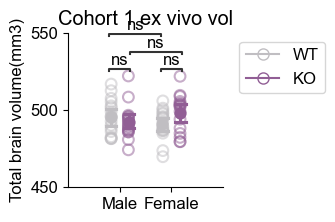

In [23]:
# Cohort 1 total brain volume ex vivo
plot_events(cohort1_exvivo, 'vol', '/Users/hannalemmik/Dropbox/KO_paper/volume/Cohort1_exvivo_total_vol.pdf', ylim=(450, 550), title='Cohort 1 ex vivo vol', ylabel='Total brain volume(mm3)')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.296e+00
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=9.804e-01
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.702e-01 stat=1.905e+00
M_WT v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.117e-03 stat=1.201e+01


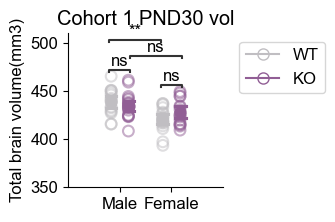

In [24]:
# Cohort 1 total brain volume PND30
plot_events(cohort1_30, 'vol', '/Users/hannalemmik/Dropbox/KO_paper/volume/cohort1_30_vol.pdf', ylim=(350, 510), title='Cohort 1 PND30 vol', ylabel='Total brain volume(mm3)')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.159e-01 stat=2.305e+00
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.047e+00
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.593e-01 stat=1.719e+00
M_WT v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.941e-01


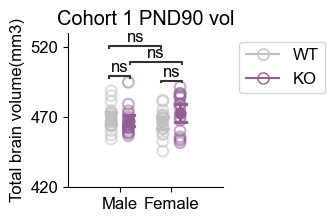

In [25]:
# Cohort 1 total brain volume PND90
plot_events(cohort1_90, 'vol', '/Users/hannalemmik/Dropbox/KO_paper/volume/cohort1_90_vol.pdf', ylim=(420, 530), title='Cohort 1 PND90 vol', ylabel='Total brain volume(mm3)')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.679e-01
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.841e-01
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.701e-03 stat=1.097e+01
M_WT v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.045e-03 stat=1.133e+01


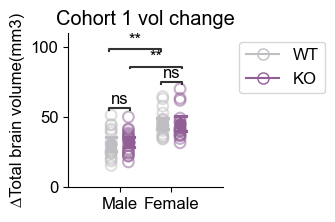

In [26]:
# ∆adulthood–adolescence total brain volume
plot_events(cohort1_30, 'maturation_change', '/Users/hannalemmik/Dropbox/KO_paper/volume/cohort1_maturationchange_vol.pdf', ylim=(0,110), title='Cohort 1 vol change', ylabel='∆Total brain volume(mm3)')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.570e-01
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.272e-02
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=0.000e+00
M_WT v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=3.589e-02


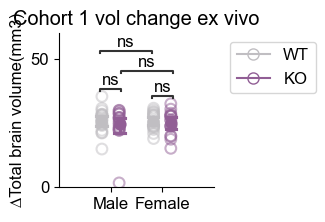

In [27]:
plot_events(cohort1_30, 'exvivo_change', '/Users/hannalemmik/Dropbox/KO_paper/volume/cohort1_exvivo_change_vol.pdf', ylim=(0,60), title='Cohort 1 vol change ex vivo', ylabel='∆Total brain volume(mm3)')

In [28]:
# NB there appears to be one outlier:
min_row = cohort1_30.loc[cohort1_30['exvivo_change'].idxmin()]
min_row_df = pd.DataFrame([min_row])
min_row_df

,subject,vol,Sex,Genotype,exvivo,90,maturation_change,exvivo_change
63,COMR421c,434.793,M,KO,474.326,472.626,37.833,1.7


## ANOVAs

In [29]:
# function to calculate Cohen's D
def cohen_d(group1, group2):
    diff_mean = group1.mean() - group2.mean()
    pooled_std = np.sqrt(((group1.std() ** 2 + group2.std() ** 2) / 2))
    return diff_mean / pooled_std

# function to calculate effect size r for Mann-Whitney U test
def effect_size_r(stat, n1, n2):
    return stat / np.sqrt(n1 * n2)

In [30]:
# check assumptions 


numerical_columns = cohort1_30.columns[4:]

# create a list to store the normality test results
normality_results_list = []

# loop through the columns to perform shapiro-wilk normality test
for column in numerical_columns:
    data = cohort1_30[column].dropna()

    if data.notna().any():
        # shapiro-wilk test
        stat, p_value = shapiro(data.dropna())
        normality_results_list.append({'outcome_measure': column, 'shapiro-statistic': stat, 'shapiro-p-value': p_value})
    else:
        # append none values for empty columns
        normality_results_list.append({'outcome_measure': column, 'shapiro-statistic': None, 'shapiro-p-value': None})

# convert the list of dictionaries into a dataframe
normality_results = pd.DataFrame(normality_results_list)

# replace empty spaces with nan
cohort1_30.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# filter data for genotypes
wt_values = cohort1_30[cohort1_30['Genotype'] == 'WT']
hom_values = cohort1_30[cohort1_30['Genotype'] == 'KO']

# create a list to store levene's test results
levene_results = []

# loop through numerical columns for levene's test
for column in numerical_columns:

    wt_data = wt_values[column].dropna()
    hom_data = hom_values[column].dropna()

    if wt_data.notna().any() and hom_data.notna().any():
        # calculate variances
        wt_var = wt_data.var()
        hom_var = hom_data.var()
        # levene's test for variance equality
        stat, p_value = levene(wt_data, hom_data)
        # append the results
        levene_results.append({
            'outcome_measure': column, 
            'levene-stat': stat, 
            'levene-p-value': p_value, 
            'wt-variance': wt_var, 
            'hom-variance': hom_var, 
            'n_wt': len(wt_data), 
            'n_hom': len(hom_data)
        })
    else:
        # append none if data is missing
        levene_results.append({
            'outcome_measure': column, 
            'levene-stat': None, 
            'levene-p-value': None, 
            'wt-variance': None, 
            'hom-variance': None, 
            'n_wt': None, 
            'n_hom': None
        })

# convert the list of dictionaries to dataframe
levene_results_df = pd.DataFrame(levene_results)

# merge the normality results and levene's test results into a single dataframe
normality_and_variance = pd.merge(normality_results, levene_results_df, on='outcome_measure')

# determine if parametric assumptions are met
normality_and_variance['parametric_assumptions_met'] = (
    (normality_and_variance['shapiro-p-value'] > 0.05) & 
    (normality_and_variance['levene-p-value'] > 0.05)
)


normality_and_variance


,outcome_measure,shapiro-statistic,shapiro-p-value,levene-stat,levene-p-value,wt-variance,hom-variance,n_wt,n_hom,parametric_assumptions_met
0,exvivo,0.985569,0.630840,0.312760,0.577913,109.207175,135.659834,34,33,True
1,90,0.977981,0.262638,2.629070,0.109620,87.616627,140.253516,35,34,True
2,maturation_change,0.972752,0.136046,0.641710,0.425924,151.773275,135.020696,35,34,True
3,exvivo_change,0.867372,0.000004,0.302061,0.584477,15.964900,31.334824,34,33,False


In [31]:
# Cohort 1 PND30 two-way ANOVA
anova_results = pg.anova(dv='vol', between=['Sex', 'Genotype'], data=cohort1_30, detailed=True)
anova_results


,Source,SS,DF,MS,F,p-unc,np2
0,Sex,2708.774554,1.0,2708.774554,16.719344,0.000122,0.204595
1,Genotype,56.543417,1.0,56.543417,0.349002,0.556727,0.005341
2,Sex * Genotype,527.575520,1.0,527.575520,3.256349,0.075780,0.047708
3,Residual,10530.936500,65.0,162.014408,NaN,NaN,NaN


In [32]:
#Cohort 2 (PND90) two-way ANOVA
anova_results = pg.anova(dv='vol', between=['Sex', 'Genotype'], data=cohort2, detailed=True)
anova_results

,Source,SS,DF,MS,F,p-unc,np2
0,Sex,212.610841,1.0,212.610841,1.335473,0.256133,0.038895
1,Genotype,208.415524,1.0,208.415524,1.309121,0.260786,0.038157
2,Sex * Genotype,589.007237,1.0,589.007237,3.699733,0.063084,0.100811
3,Residual,5253.686814,33.0,159.202631,NaN,NaN,NaN


In [33]:
# Cohort 2 PND90 two-way ANOVA
anova_results = pg.anova(dv='vol', between=['Sex', 'Genotype'], data=cohort1_90, detailed=True)
anova_results

,Source,SS,DF,MS,F,p-unc,np2
0,Sex,29.153804,1.0,29.153804,0.262906,0.609869,0.004028
1,Genotype,82.659458,1.0,82.659458,0.745413,0.391107,0.011338
2,Sex * Genotype,370.275233,1.0,370.275233,3.339098,0.072243,0.048861
3,Residual,7207.902296,65.0,110.890805,NaN,NaN,NaN


In [34]:
# Cohort 1 maturation change 
anova_results = pg.anova(dv='maturation_change', between=['Sex', 'Genotype'], data=cohort1_30, detailed=True)
anova_results


,Source,SS,DF,MS,F,p-unc,np2
0,Sex,3299.964233,1.0,3299.964233,34.035778,1.864484e-07,0.343672
1,Genotype,2.471778,1.0,2.471778,0.025494,8.736377e-01,0.000392
2,Sex * Genotype,13.886617,1.0,13.886617,0.143226,7.063277e-01,0.002199
3,Residual,6302.123450,65.0,96.955745,NaN,NaN,NaN
